In [183]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table


## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/24 05:39:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
#end_date_str = "2023-1-01"
end_date_str = "2024-12-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

## Build Bronze Table

In [5]:
# create bronze datalake
bronze_lms_directory = "datamart/bronze/lms/"
bronze_clickstream_directory = "datamart/bronze/users/clickstream/"
bronze_attributes_directory = "datamart/bronze/users/attributes/"
bronze_financials_directory = "datamart/bronze/users/financials/"

if not os.path.exists(bronze_lms_directory):
    os.makedirs(bronze_lms_directory)

if not os.path.exists(bronze_clickstream_directory):
    os.makedirs(bronze_clickstream_directory)

if not os.path.exists(bronze_attributes_directory):
    os.makedirs(bronze_attributes_directory)

if not os.path.exists(bronze_financials_directory):
    os.makedirs(bronze_financials_directory)

In [6]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_loans(date_str, bronze_lms_directory, spark)
    utils.data_processing_bronze_table.process_bronze_users(date_str, bronze_clickstream_directory, bronze_attributes_directory, bronze_financials_directory, spark)

2023-01-01 row count: 530
saved to: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv
2023-01-01 row count (clickstream): 8974
saved to: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_01_01.csv
2023-01-01 row count (attributes): 530
saved to: datamart/bronze/users/attributes/bronze_users_attributes_2023_01_01.csv
2023-01-01 row count (financials): 530
saved to: datamart/bronze/users/financials/bronze_users_financials_2023_01_01.csv
2023-02-01 row count: 1031
saved to: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv
2023-02-01 row count (clickstream): 8974
saved to: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_02_01.csv
2023-02-01 row count (attributes): 501
saved to: datamart/bronze/users/attributes/bronze_users_attributes_2023_02_01.csv
2023-02-01 row count (financials): 501
saved to: datamart/bronze/users/financials/bronze_users_financials_2023_02_01.csv
2023-03-01 row count: 1537
saved to: datamart/bronze/lms/bronze_loan_daily_2023_03_01.c

In [7]:
# inspect output
loans_df = utils.data_processing_bronze_table.process_bronze_loans(date_str, bronze_lms_directory, spark)
click_df, attr_df, fin_df = utils.data_processing_bronze_table.process_bronze_users(date_str, bronze_clickstream_directory, 
                                                                                    bronze_attributes_directory, bronze_financials_directory, 
                                                                                    spark)

2024-12-01 row count: 5531
saved to: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv
2024-12-01 row count (clickstream): 8974
saved to: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_12_01.csv
2024-12-01 row count (attributes): 515
saved to: datamart/bronze/users/attributes/bronze_users_attributes_2024_12_01.csv
2024-12-01 row count (financials): 515
saved to: datamart/bronze/users/financials/bronze_users_financials_2024_12_01.csv


In [8]:
loans_df.limit(5).toPandas()

,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x100b_2024_03_01,CUS_0x100b,2024-03-01,10,9,10000,1000.0,1000.0,0.0,1000.0,2024-12-01
1,CUS_0x102e_2024_04_01,CUS_0x102e,2024-04-01,10,8,10000,1000.0,0.0,6000.0,8000.0,2024-12-01
2,CUS_0x1038_2024_10_01,CUS_0x1038,2024-10-01,10,2,10000,1000.0,1000.0,0.0,8000.0,2024-12-01
3,CUS_0x103e_2024_12_01,CUS_0x103e,2024-12-01,10,0,10000,0.0,0.0,0.0,10000.0,2024-12-01
4,CUS_0x1048_2024_02_01,CUS_0x1048,2024-02-01,10,10,10000,1000.0,0.0,9000.0,9000.0,2024-12-01


In [9]:
loans_df.dtypes

[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('loan_start_date', 'date'),
 ('tenure', 'int'),
 ('installment_num', 'int'),
 ('loan_amt', 'int'),
 ('due_amt', 'double'),
 ('paid_amt', 'double'),
 ('overdue_amt', 'double'),
 ('balance', 'double'),
 ('snapshot_date', 'date')]

In [10]:
click_df.limit(5).toPandas()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01


In [11]:
click_df.dtypes

[('fe_1', 'int'),
 ('fe_2', 'int'),
 ('fe_3', 'int'),
 ('fe_4', 'int'),
 ('fe_5', 'int'),
 ('fe_6', 'int'),
 ('fe_7', 'int'),
 ('fe_8', 'int'),
 ('fe_9', 'int'),
 ('fe_10', 'int'),
 ('fe_11', 'int'),
 ('fe_12', 'int'),
 ('fe_13', 'int'),
 ('fe_14', 'int'),
 ('fe_15', 'int'),
 ('fe_16', 'int'),
 ('fe_17', 'int'),
 ('fe_18', 'int'),
 ('fe_19', 'int'),
 ('fe_20', 'int'),
 ('Customer_ID', 'string'),
 ('snapshot_date', 'date')]

In [12]:
attr_df.limit(5).toPandas()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x103e,Tim Kellyf,40,155-72-8070,Scientist,2024-12-01
1,CUS_0x1195,Alexk,31,822-48-3629,Manager,2024-12-01
2,CUS_0x1197,Nayako,28,799-23-8283,_______,2024-12-01
3,CUS_0x11e2,Valetkevitchr,34,809-04-1419,Musician,2024-12-01
4,CUS_0x11ec,William Schombergh,34,417-74-2163,Journalist,2024-12-01


In [13]:
fin_df.limit(5).toPandas()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x103e,98690.8,8262.233333,4,6,9,1_,Student Loan,6,17,...,Good,706.96,26.860663,26 Years and 11 Months,No,55.004408,913.4813186573292,Low_spent_Small_value_payments,147.7376071067124,2024-12-01
1,CUS_0x1195,30429.91,2808.825833,4,6,16,2,"Auto Loan, and Auto Loan",22,17,...,Standard,362.48,33.349050,28 Years and 11 Months,No,29.914076,82.87878577514347,Low_spent_Large_value_payments,438.08972109416084,2024-12-01
2,CUS_0x1197,92300.01,7437.667500,2,4,11,3,"Credit-Builder Loan, Not Specified, and Credit...",27,9,...,_,755.17_,26.989787,18 Years and 11 Months,Yes,49236.000000,220.8621525417414,Low_spent_Large_value_payments,581.1567885447394,2024-12-01
3,CUS_0x11e2,44986.55,3689.879167,6,5,11,1,Credit-Builder Loan,0,4,...,Good,753.21,25.586286,20 Years and 0 Months,No,23.267135,43.20363344633164,High_spent_Large_value_payments,542.5171477430948,2024-12-01
4,CUS_0x11ec,14867.69,1005.974167,9,9,18,6,"Debt Consolidation Loan, Student Loan, Persona...",39,15,...,Standard,2344.06,24.344388,17 Years and 2 Months,Yes,55.459604,100.14574834721886,Low_spent_Medium_value_payments,224.99206407779144,2024-12-01


In [14]:
fin_df.dtypes

[('Customer_ID', 'string'),
 ('Annual_Income', 'string'),
 ('Monthly_Inhand_Salary', 'double'),
 ('Num_Bank_Accounts', 'int'),
 ('Num_Credit_Card', 'int'),
 ('Interest_Rate', 'int'),
 ('Num_of_Loan', 'string'),
 ('Type_of_Loan', 'string'),
 ('Delay_from_due_date', 'int'),
 ('Num_of_Delayed_Payment', 'string'),
 ('Changed_Credit_Limit', 'string'),
 ('Num_Credit_Inquiries', 'double'),
 ('Credit_Mix', 'string'),
 ('Outstanding_Debt', 'string'),
 ('Credit_Utilization_Ratio', 'double'),
 ('Credit_History_Age', 'string'),
 ('Payment_of_Min_Amount', 'string'),
 ('Total_EMI_per_month', 'double'),
 ('Amount_invested_monthly', 'string'),
 ('Payment_Behaviour', 'string'),
 ('Monthly_Balance', 'string'),
 ('snapshot_date', 'date')]

## EDA on user clickstream feature

In [56]:
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(os.path.join(bronze_clickstream_directory, "*.csv")))

click_pdf = df.toPandas()

### Check duplicated customer id with same snapshot date

In [58]:
print(click_pdf.duplicated(['Customer_ID', 'snapshot_date']).sum())

0


### Check missing values

In [17]:
print(click_pdf.isnull().sum())

fe_1             0
fe_2             0
fe_3             0
fe_4             0
fe_5             0
fe_6             0
fe_7             0
fe_8             0
fe_9             0
fe_10            0
fe_11            0
fe_12            0
fe_13            0
fe_14            0
fe_15            0
fe_16            0
fe_17            0
fe_18            0
fe_19            0
fe_20            0
Customer_ID      0
snapshot_date    0
dtype: int64


## EDA on user attributes feature

In [18]:
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(os.path.join(bronze_attributes_directory, "*.csv")))

attr_pdf = df.toPandas()

### Check duplicated customer id with same snapshot date

In [19]:
print(attr_pdf.duplicated(['Customer_ID', 'snapshot_date']).sum())

0


### Check missing values

In [20]:
print(attr_pdf.isnull().sum())

Customer_ID      0
Name             0
Age              0
SSN              0
Occupation       0
snapshot_date    0
dtype: int64


In [21]:
attr_pdf.describe(include='all')

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
count,11974,11974,11974,11974,11974,11974
unique,11974,9777,291,11299,16,24
top,CUS_0xfe4,Langep,32,#F%$D@*&8,_______,2024-08-01
freq,1,6,344,676,846,543


### Check unique string that may require cleansing and standardize

In [22]:
print(attr_pdf['Name'].unique())
print(attr_pdf['Age'].unique())
print(attr_pdf['SSN'].unique())
print(attr_pdf['Occupation'].unique())

['Zhouy' 'Moony' 'Blenkinsopr' ... 'Olaoyes' 'Mirwaisd' 'Sarah McBriden']
['29' '24' '26_' '48' '5656' '34_' '30' '40' '32' '15' '46' '52' '20' '27'
 '39' '35' '33' '41' '28' '23' '26' '54' '56' '44' '27_' '34' '16' '50_'
 '40_' '45_' '32_' '53' '22_' '25' '31' '45' '37' '21' '42' '49' '38' '18'
 '3640' '22' '19' '17' '30_' '55' '1388' '24_' '36' '29_' '43' '51' '-500'
 '47' '2672' '21_' '51_' '41_' '8125' '3441' '50' '2598' '16_' '28_'
 '3856' '38_' '8467' '2329_' '8100' '39_' '18_' '6283' '15_' '31_' '42_'
 '23_' '48_' '8547' '1094' '8448' '43_' '2038' '203' '14' '35_' '2604'
 '7459' '37_' '1814' '3834_' '54_' '19_' '36_' '52_' '4670' '2778' '25_'
 '506' '4431' '395' '3052' '5784' '47_' '53_' '5498' '2160' '33_' '448'
 '6043' '17_' '4536' '4049' '1265' '509' '4746' '5959' '2318' '6280' '44_'
 '5645' '4351' '6728' '4909' '7279' '46_' '55_' '8628' '6657' '344' '6113'
 '20_' '1990' '3493' '4120' '7139' '7123' '325' '56_' '8199' '6849' '6991'
 '8216' '4458' '8442' '4391' '3513' '7342' '5

## EDA on user financials feature

In [23]:
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(os.path.join(bronze_financials_directory, "*.csv")))

fin_pdf = df.toPandas()

### Check duplicated customer id with same snapshot date

In [24]:
print(fin_pdf.duplicated(['Customer_ID', 'snapshot_date']).sum())

0


### Check missing values

In [25]:
print(fin_pdf.isnull().sum())

Customer_ID                    0
Annual_Income                  0
Monthly_Inhand_Salary          0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                1368
Delay_from_due_date            0
Num_of_Delayed_Payment         0
Changed_Credit_Limit           0
Num_Credit_Inquiries           0
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly        0
Payment_Behaviour              0
Monthly_Balance                0
snapshot_date                  0
dtype: int64


### Check unique string that may require cleansing and standardize

In [26]:
fin_pdf.describe(include='object')

,Customer_ID,Annual_Income,Num_of_Loan,Type_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
count,11974,11974,11974,10606,11974,11974,11974,11974,11974,11974,11974,11974,11974,11974
unique,11974,11967,85,6016,166,2962,4,11713,392,3,11414,7,11974,24
top,CUS_0xff6,17273.83,3,Not Specified,19,_,Standard,1360.45,19 Years and 9 Months,Yes,__10000__,Low_spent_Small_value_payments,592.0056861539196,2024-08-01
freq,1,2,1731,170,711,246,4287,3,76,6291,540,3064,1,543


In [27]:
def uniques_not_float_pd(s: pd.Series):
    mask_nonempty = s.astype("string").str.strip().notna() & (s.astype("string").str.strip() != "")
    as_float = pd.to_numeric(s, errors="coerce")
    return s[mask_nonempty & as_float.isna()].unique()

In [28]:
print("Annual_Income:",
      uniques_not_float_pd(fin_pdf['Annual_Income'])[:5])

print("Num_of_Loan:",
      uniques_not_float_pd(fin_pdf['Num_of_Loan'])[:5])

print("Type_of_Loan:",
      fin_pdf['Type_of_Loan'].unique())

print("Num_of_Delayed_Payment:",
      uniques_not_float_pd(fin_pdf['Num_of_Delayed_Payment'])[:5])

print("Changed_Credit_Limit:",
      uniques_not_float_pd(fin_pdf['Changed_Credit_Limit'])[:5])

print("Credit_Mix",
      fin_pdf['Credit_Mix'].unique())

print("Outstanding_Debt:",
      uniques_not_float_pd(fin_pdf['Outstanding_Debt'])[:5])

print("Credit_History_Age:",
      fin_pdf['Credit_History_Age'].unique())

print("Payment_of_Min_Amount:",
      fin_pdf['Payment_of_Min_Amount'].unique())

print("Amount_invested_monthly:",
      uniques_not_float_pd(fin_pdf['Amount_invested_monthly'])[:5])

print("Payment_Behaviour:",
      fin_pdf['Payment_Behaviour'].unique())

print("Monthly_Balance:",
      uniques_not_float_pd(fin_pdf['Monthly_Balance'])[:5])


Annual_Income: ['32370.6_' '33410.45_' '40019.0_' '18811.58_' '18753.34_']
Num_of_Loan: ['3_' '4_' '5_' '2_' '6_']
Type_of_Loan: ['Credit-Builder Loan, Credit-Builder Loan, Home Equity Loan, and Debt Consolidation Loan'
 'Payday Loan'
 'Student Loan, Payday Loan, Not Specified, Mortgage Loan, Home Equity Loan, Payday Loan, Payday Loan, Not Specified, and Credit-Builder Loan'
 ...
 'Credit-Builder Loan, Not Specified, Credit-Builder Loan, Mortgage Loan, Credit-Builder Loan, Debt Consolidation Loan, and Home Equity Loan'
 'Auto Loan, Personal Loan, Student Loan, Personal Loan, Auto Loan, Auto Loan, and Credit-Builder Loan'
 'Debt Consolidation Loan, Home Equity Loan, Personal Loan, Debt Consolidation Loan, Payday Loan, Mortgage Loan, and Auto Loan']
Num_of_Delayed_Payment: ['12_' '20_' '13_' '3_' '4_']
Changed_Credit_Limit: ['_']
Credit_Mix ['_' 'Good' 'Bad' 'Standard']
Outstanding_Debt: ['30.31_' '127.88_' '270.42_' '758.45_' '422.57_']
Credit_History_Age: ['16 Years and 3 Months' '30 Y

## Build Silver Table

In [29]:
# create bronze datalake
silver_loan_daily_directory = "datamart/silver/loan_daily/"
silver_clickstream_directory = "datamart/silver/users/clickstream/"
silver_attributes_directory = "datamart/silver/users/attributes/"
silver_financials_directory = "datamart/silver/users/financials/"

if not os.path.exists(silver_loan_daily_directory):
    os.makedirs(silver_loan_daily_directory)
    
if not os.path.exists(silver_clickstream_directory):
    os.makedirs(silver_clickstream_directory)

if not os.path.exists(silver_attributes_directory):
    os.makedirs(silver_attributes_directory)

if not os.path.exists(silver_financials_directory):
    os.makedirs(silver_financials_directory)

In [30]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_loans(date_str, bronze_lms_directory, silver_loan_daily_directory, spark)
    utils.data_processing_silver_table.process_silver_users(date_str, bronze_clickstream_directory, bronze_attributes_directory, \
                                                            bronze_financials_directory, silver_clickstream_directory, \
                                                            silver_attributes_directory, silver_financials_directory, spark)


loaded from: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv row count: 530


saved to: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_01_01.csv row count: 530
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_01_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_01_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2023_01_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_01_01.csv row count: 530


saved to: datamart/silver/users/financials/silver_users_financials_2023_01_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv row count: 1031
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_02_01.csv row count: 501
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_02_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_02_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2023_02_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_02_01.csv row count: 501
saved to: datamart/silver/users/financials/silver_users_financials_2023_02_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv row count: 1537
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_03_01.csv row count: 506
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_03_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_03_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2023_03_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_03_01.csv row count: 506
saved to: datamart/silver/users/financials/silver_users_financials_2023_03_01.parquet
l

saved to: datamart/silver/users/attributes/silver_users_attributes_2023_06_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_06_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2023_06_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2023_06_01.csv row count: 517
saved to: datamart/silver/users/financials/silver_users_financials_2023_06_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_07_01.csv row count: 3556
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_07_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2023_07_01.csv row count: 471
saved to: datamart/silver/users/attributes/silver_users_attributes_2023_07_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2023_07_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2023_07_01.parque

saved to: datamart/silver/users/attributes/silver_users_attributes_2024_01_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_01_01.csv row count: 8974


saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2024_01_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_01_01.csv row count: 485
saved to: datamart/silver/users/financials/silver_users_financials_2024_01_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_02_01.csv row count: 5424
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_02_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_02_01.csv row count: 518
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_02_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_02_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2024_02_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_02_01.csv row count: 518
saved to: datamart/silver/users/financials/silver_users_financials_2024_02_01.parquet
l

saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2024_05_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_05_01.csv row count: 491
saved to: datamart/silver/users/financials/silver_users_financials_2024_05_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_06_01.csv row count: 5418
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_06_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_06_01.csv row count: 498
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_06_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_06_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2024_06_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_06_01.csv row count: 498


saved to: datamart/silver/users/financials/silver_users_financials_2024_06_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_07_01.csv row count: 5442
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_07_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_07_01.csv row count: 505
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_07_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_07_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2024_07_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_07_01.csv row count: 505
saved to: datamart/silver/users/financials/silver_users_financials_2024_07_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_08_01.csv row count: 5531
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_08_01.parquet
loaded from: datamart/bronze/users/a

saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2024_08_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_08_01.csv row count: 543
saved to: datamart/silver/users/financials/silver_users_financials_2024_08_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_09_01.csv row count: 5537
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_09_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_09_01.csv row count: 493
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_09_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_09_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2024_09_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_09_01.csv row count: 493
saved to: datamart/silver/users/financials/silver_users_financials_2024_09_01.parquet
l

saved to: datamart/silver/users/attributes/silver_users_attributes_2024_12_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_12_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2024_12_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_12_01.csv row count: 515
saved to: datamart/silver/users/financials/silver_users_financials_2024_12_01.parquet


In [32]:
utils.data_processing_silver_table.process_silver_loans(date_str, bronze_lms_directory, silver_loan_daily_directory, spark).toPandas()
click_df, attr_df, fin_df = utils.data_processing_silver_table.process_silver_users(date_str, bronze_clickstream_directory, bronze_attributes_directory, \
                                                                                    bronze_financials_directory, silver_clickstream_directory, \
                                                                                    silver_attributes_directory, silver_financials_directory, spark)

loaded from: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv row count: 5531
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet
loaded from: datamart/bronze/users/attributes/bronze_users_attributes_2024_12_01.csv row count: 515
saved to: datamart/silver/users/attributes/silver_users_attributes_2024_12_01.parquet
loaded from: datamart/bronze/users/clickstream/bronze_users_clickstream_2024_12_01.csv row count: 8974
saved to: datamart/silver/users/clickstream/silver_users_clickstream_df_2024_12_01.parquet
loaded from: datamart/bronze/users/financials/bronze_users_financials_2024_12_01.csv row count: 515
saved to: datamart/silver/users/financials/silver_users_financials_2024_12_01.parquet


In [33]:
click_pdf = click_df.toPandas()

In [34]:
click_pdf.head()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01


In [35]:
click_pdf.dtypes

fe_1              int32
fe_2              int32
fe_3              int32
fe_4              int32
fe_5              int32
fe_6              int32
fe_7              int32
fe_8              int32
fe_9              int32
fe_10             int32
fe_11             int32
fe_12             int32
fe_13             int32
fe_14             int32
fe_15             int32
fe_16             int32
fe_17             int32
fe_18             int32
fe_19             int32
fe_20             int32
Customer_ID      object
snapshot_date    object
dtype: object

In [36]:
attr_pdf = attr_df.toPandas()

In [37]:
attr_pdf.head()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,Name_Masked,SSN_Masked,Hashed_User_ID
0,CUS_0x103e,Tim Kellyf,40.0,155-72-8070,Scientist,2024-12-01,T*********,XXX-XX-8070,0481ab36b74202971b9e5c3ef8f92d88b41196ff6df9e2...
1,CUS_0x1195,Alexk,31.0,822-48-3629,Manager,2024-12-01,A****,XXX-XX-3629,579fbacacfebadd7ae35f7ec0e73f296d03aaa1358f1d5...
2,CUS_0x1197,Nayako,28.0,799-23-8283,None,2024-12-01,N*****,XXX-XX-8283,76fe30802ff587411d05f041c8c393b0eee3b4cbd9839b...
3,CUS_0x11e2,Valetkevitchr,34.0,809-04-1419,Musician,2024-12-01,V************,XXX-XX-1419,0a34afb357a008b14c964ba302a793411e207a9828dad6...
4,CUS_0x11ec,William Schombergh,34.0,417-74-2163,Journalist,2024-12-01,W*****************,XXX-XX-2163,b9913cc4b0a43c53e3406a24ffadd74dc7c75a5d158348...


In [38]:
attr_pdf.isnull().sum()

Customer_ID        0
Name               0
Age               45
SSN               30
Occupation        33
snapshot_date      0
Name_Masked        0
SSN_Masked        30
Hashed_User_ID     0
dtype: int64

In [39]:
attr_pdf.describe()

,Age
count,470.000000
mean,34.336170
std,10.258169
min,18.000000
25%,25.000000
50%,34.000000
75%,42.750000
max,56.000000


In [40]:
attr_pdf.dtypes

Customer_ID        object
Name               object
Age               float64
SSN                object
Occupation         object
snapshot_date      object
Name_Masked        object
SSN_Masked         object
Hashed_User_ID     object
dtype: object

In [41]:
fin_pdf = fin_df.toPandas()

In [42]:
fin_pdf.head()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,snapshot_date,Payment_Behaviour_Spent,Payment_Behaviour_Payment
0,CUS_0x103e,98690.796875,8262.233398,4,6,9.0,1,Student Loan,6,17,...,706.960022,26.860664,323,N,55.004406,913.481323,147.737610,2024-12-01,Low,Small
1,CUS_0x1195,30429.910156,2808.825928,4,6,16.0,2,Auto Loan,22,17,...,362.480011,33.349049,347,N,29.914076,82.878784,438.089722,2024-12-01,Low,Large
2,CUS_0x1197,92300.007812,7437.667480,2,4,11.0,3,Credit-Builder Loan,27,9,...,755.169983,26.989786,227,Y,49236.000000,220.862152,581.156799,2024-12-01,Low,Large
3,CUS_0x11e2,44986.550781,3689.879150,6,5,11.0,1,Credit-Builder Loan,0,4,...,753.210022,25.586287,240,N,23.267136,43.203632,542.517151,2024-12-01,High,Large
4,CUS_0x11ec,14867.690430,1005.974182,9,9,18.0,6,Debt Consolidation Loan|Student Loan|Personal ...,39,15,...,2344.060059,24.344387,206,Y,55.459602,100.145752,224.992065,2024-12-01,Low,Medium


In [43]:
fin_pdf[fin_pdf['Customer_ID'] == 'CUS_0x1069']

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,snapshot_date,Payment_Behaviour_Spent,Payment_Behaviour_Payment


In [44]:
fin_pdf.isnull().sum()

Customer_ID                    0
Annual_Income                  0
Monthly_Inhand_Salary          0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                  58
Delay_from_due_date            0
Num_of_Delayed_Payment         0
Changed_Credit_Limit          10
Num_Credit_Inquiries           0
Credit_Mix                   106
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly        0
Monthly_Balance                0
snapshot_date                  0
Payment_Behaviour_Spent       46
Payment_Behaviour_Payment     46
dtype: int64

In [45]:
fin_pdf.describe()

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,5.150000e+02,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,505.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,1.749363e+05,4416.044434,14.333981,19.273786,54.093204,8.700971,19.710680,39.361165,10.300019,19.349515,1278.512451,32.552391,233.473786,1792.441406,608.821716,412.603333
std,1.294088e+06,3126.284424,93.075161,118.984324,385.073547,114.684731,13.534212,250.184908,6.506264,121.807888,1044.662842,5.204227,94.038555,8842.627930,1947.748169,217.049042
min,7.630570e+03,467.338745,0.000000,0.000000,1.000000,-100.000000,-4.000000,-3.000000,-5.370000,0.000000,0.340000,21.502216,10.000000,0.000000,12.790792,16.787592
25%,2.223058e+04,1896.409546,3.000000,4.000000,7.000000,1.000000,10.000000,9.000000,5.400000,4.000000,476.369995,28.248892,167.500000,30.053956,80.341499,277.044662
50%,4.276789e+04,3421.373291,5.000000,5.000000,12.000000,3.000000,16.000000,13.000000,9.520000,6.000000,1082.800049,32.678150,232.000000,75.309364,149.591202,354.518768
75%,7.254443e+04,6027.388428,7.000000,7.000000,19.000000,5.000000,27.000000,17.000000,14.610000,9.000000,1698.765015,36.927961,309.500000,180.783310,292.739273,483.138153
max,1.765555e+07,14978.336914,1413.000000,1479.000000,5709.000000,1430.000000,65.000000,3107.000000,31.920000,1549.000000,4862.799805,45.783989,401.000000,70242.000000,10000.000000,1400.426392


In [46]:
fin_pdf.dtypes

Customer_ID                   object
Annual_Income                float32
Monthly_Inhand_Salary        float32
Num_Bank_Accounts              int32
Num_Credit_Card                int32
Interest_Rate                float32
Num_of_Loan                    int32
Type_of_Loan                  object
Delay_from_due_date            int32
Num_of_Delayed_Payment         int32
Changed_Credit_Limit         float32
Num_Credit_Inquiries           int32
Credit_Mix                    object
Outstanding_Debt             float32
Credit_Utilization_Ratio     float32
Credit_History_Age             int32
Payment_of_Min_Amount         object
Total_EMI_per_month          float32
Amount_invested_monthly      float32
Monthly_Balance              float32
snapshot_date                 object
Payment_Behaviour_Spent       object
Payment_Behaviour_Payment     object
dtype: object

## EDA on credit labels

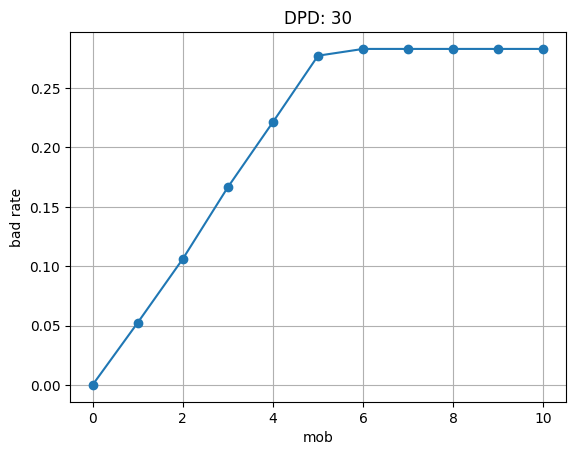

In [47]:
# set dpd label definition
dpd = 30

# Path to the folder containing CSV files
folder_path = silver_loan_daily_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


In [48]:
df.show()

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|             loan_id|Customer_ID|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|dpd|dpd_flag|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|CUS_0x1011_2023_1...| CUS_0x1011|     2023-11-01|    10|             10| 10000.0| 1000.0|  1000.0|        0.0|    0.0|   2024-09-01| 10|                  0|             NULL|  0|       0|
|CUS_0x1013_2023_1...| CUS_0x1013|     2023-12-01|    10|              9| 10000.0| 1000.0|  1000.0|        0.0| 1000.0|   2024-09-01|  9|                  0|             NULL|  0|       0|
|CUS_0x1018_2023_1...| CUS_0x1018|     2023-11-01|    1

## EDA on features

In [ ]:
folder_path = silver_clickstream_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

silver_click_pdf = df.toPandas()

folder_path = silver_attributes_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

silver_attr_pdf = df.toPandas()

folder_path = silver_financials_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

silver_finanicial_pdf = df.toPandas()

In [112]:
silver_attr_pdf

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,Name_Masked,SSN_Masked,Hashed_User_ID
0,CUS_0x10ac,Zhouy,29.0,780-50-4730,Developer,2024-08-01,Z****,XXX-XX-4730,84c9bf86c287f6971a989157ce2f151bbc4b193f8e40d0...
1,CUS_0x10c5,Moony,24.0,041-74-6785,None,2024-08-01,M****,XXX-XX-6785,b32206eeaf50a37c361ac98d790c84f546c65f0f67779a...
2,CUS_0x1145,Blenkinsopr,24.0,426-31-9194,Teacher,2024-08-01,B**********,XXX-XX-9194,9fbf1035627d1ee1b1a7ddfd758899766195aab00b1c47...
3,CUS_0x11ac,Liana B.v,26.0,835-92-7751,Journalist,2024-08-01,L********,XXX-XX-7751,ba920f11c5c0105932cad7bb5adbb72e7dd1393ef951d1...
4,CUS_0x122c,Papadimasf,48.0,883-73-9594,Entrepreneur,2024-08-01,P*********,XXX-XX-9594,a7e022c0c11b34e0b65edbbbfce1c0ca5b98798a3a43f3...
...,...,...,...,...,...,...,...,...,...
11969,CUS_0xdf6,Euan Rochaa,55.0,155-73-3803,Mechanic,2023-09-01,E**********,XXX-XX-3803,97feb8a10b7cbda29d9b2a7a70a2ef4e1f580c097ad13a...
11970,CUS_0xe23,Soyoung Kimg,39.0,825-49-2383,Musician,2023-09-01,S***********,XXX-XX-2383,9fc2629dd73f376fbe249d8e7285322dee276656aa3100...
11971,CUS_0xe4e,Mirwaisd,22.0,952-71-5963,Scientist,2023-09-01,M*******,XXX-XX-5963,0aadb6278aeb0022c01adb64bd9b6905de9f060025f11b...
11972,CUS_0xedd,Lauren Tarao,NaN,888-82-5609,Engineer,2023-09-01,L***********,XXX-XX-5609,c6faee11a5d5c137b328a5d2ebf62a3e713df6095aee44...


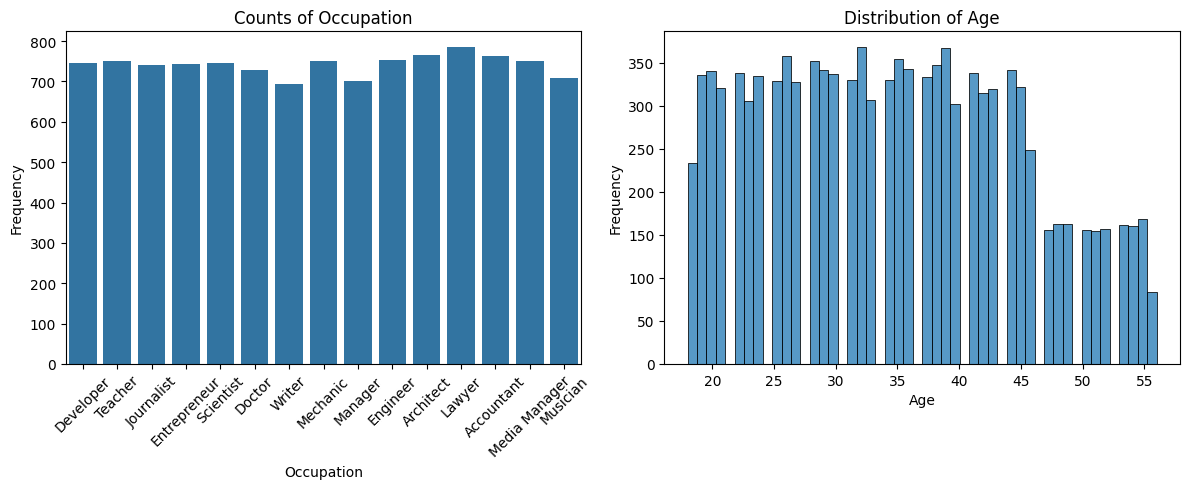

In [190]:
# Create figure and axis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Occupation counts (categorical)
sns.countplot(data=silver_attr_pdf, x="Occupation", ax=axes[0])
axes[0].set_xlabel("Occupation")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Counts of Occupation")
axes[0].tick_params(axis="x", rotation=45)

# Plot Age histogram (numeric)
sns.histplot(data=silver_attr_pdf, x="Age", bins=50, ax=axes[1])
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Age")

plt.tight_layout()
plt.show()

In [166]:
silver_finanicial_pdf

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,snapshot_date,Payment_Behaviour_Spent,Payment_Behaviour_Payment
0,CUS_0x10ac,16718.644531,1270.220459,7,3,15.0,4,Credit-Builder Loan|Home Equity Loan|Debt Cons...,26,11,...,853.409973,31.397339,195,N,50.961937,36.413094,319.647003,2024-08-01,None,None
1,CUS_0x10c5,158623.156250,13180.596680,2,7,10.0,1,Payday Loan,10,5,...,1134.829956,41.796799,362,N,91.033905,282.718689,1194.307129,2024-08-01,High,Medium
2,CUS_0x1145,17975.320312,1444.943359,6,5,32.0,9,Student Loan|Payday Loan|Mortgage Loan|Home Eq...,61,25,...,1263.099976,25.681799,149,Y,76.450325,176.776215,181.267792,2024-08-01,Low,Small
3,CUS_0x11ac,69136.539062,5902.378418,3,4,14.0,0,None,14,18,...,478.850006,32.103165,209,Y,0.000000,435.937012,444.300842,2024-08-01,Low,Small
4,CUS_0x122c,36346.128906,3188.844238,8,6,11.0,3,Credit-Builder Loan|Home Equity Loan|Auto Loan,21,15,...,1252.459961,28.066704,266,N,89.061554,110.509705,369.313171,2024-08-01,High,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11969,CUS_0xdf6,40453.851562,2772.811035,2,2,1.0,0,None,13,5,...,454.359985,38.966488,219,N,323.343109,245.687485,353.927948,2023-09-01,Low,Small
11970,CUS_0xe23,17815.585938,1427.632080,8,6,18.0,1,Home Equity Loan,25,14,...,982.630005,33.897781,371,Y,13.346552,69.658859,339.757812,2023-09-01,Low,Medium
11971,CUS_0xe4e,108073.679688,8738.139648,3,3,9.0,0,None,29,14,...,1323.250000,38.327251,237,Y,0.000000,366.554504,757.259460,2023-09-01,High,Medium
11972,CUS_0xedd,125468.437500,10445.703125,4,4,10.0,4,Payday Loan|Credit-Builder Loan|Personal Loan|...,18,13,...,1136.849976,39.053761,238,Y,338.092407,590.021301,376.456635,2023-09-01,High,Small


In [113]:
silver_click_pdf.duplicated(['Customer_ID']).sum()

np.int64(206402)

In [114]:
silver_attr_pdf.duplicated(['Customer_ID']).sum()

np.int64(0)

In [115]:
silver_finanicial_pdf.duplicated(['Customer_ID']).sum()

np.int64(0)

In [116]:
silver_click_pdf.groupby("Customer_ID").count()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,snapshot_date
Customer_ID,,,,,,,,,,,,,,,,,,,,,
CUS_0x1000,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0x100b,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0x1011,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0x1013,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0x1015,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CUS_0xfe5,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0xfea,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
CUS_0xff3,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24


## Build gold table for labels

In [50]:
# create bronze datalake
gold_label_store_directory = "datamart/gold/label_store/"
gold_feature_store_directory = "datamart/gold/feature_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [52]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6)


loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet row count: 530
saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet row count: 1031
saved to: datamart/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet row count: 1537


saved to: datamart/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_04_01.parquet row count: 2047
saved to: datamart/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_05_01.parquet row count: 2568
saved to: datamart/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_06_01.parquet row count: 3085
saved to: datamart/gold/label_store/gold_label_store_2023_06_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_07_01.parquet row count: 3556
saved to: datamart/gold/label_store/gold_label_store_2023_07_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_08_01.parquet row count: 4037


saved to: datamart/gold/label_store/gold_label_store_2023_08_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_09_01.parquet row count: 4491
saved to: datamart/gold/label_store/gold_label_store_2023_09_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_10_01.parquet row count: 4978
saved to: datamart/gold/label_store/gold_label_store_2023_10_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_11_01.parquet row count: 5469
saved to: datamart/gold/label_store/gold_label_store_2023_11_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_12_01.parquet row count: 5428
saved to: datamart/gold/label_store/gold_label_store_2023_12_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_01_01.parquet row count: 5412
saved to: datamart/gold/label_store/gold_label_store_2024_01_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_02_01.parquet row count: 5424
saved to: 

saved to: datamart/gold/label_store/gold_label_store_2024_09_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_10_01.parquet row count: 5502
saved to: datamart/gold/label_store/gold_label_store_2024_10_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_11_01.parquet row count: 5501
saved to: datamart/gold/label_store/gold_label_store_2024_11_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet


In [53]:
utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6).dtypes


loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet


[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('label', 'int'),
 ('label_def', 'string'),
 ('snapshot_date', 'date')]

## inspect label store

In [67]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [68]:
df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)



In [69]:
gold_loans_pdf = df.toPandas()

In [102]:
folder_path = silver_attributes_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

silver_attr_pdf = df.toPandas()

folder_path = silver_clickstream_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

silver_click_pdf = df.toPandas()

folder_path = silver_financials_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

silver_finanicial_pdf = df.toPandas()

row_count: 11974
row_count: 215376


row_count: 11974


In [ ]:
gold_loans_pdf

In [132]:
gold_cust_id = gold_loans_pdf[["Customer_ID", "snapshot_date"]]
gold_cust_id = cust_id.rename(columns={"snapshot_date": "snapshot_date_cust"})

In [133]:
gold_cust_id

,Customer_ID,snapshot_date_cust
0,CUS_0x1037,2023-07-01
1,CUS_0x1069,2023-07-01
2,CUS_0x114a,2023-07-01
3,CUS_0x1184,2023-07-01
4,CUS_0x1297,2023-07-01
...,...,...
8969,CUS_0xdf6,2024-03-01
8970,CUS_0xe23,2024-03-01
8971,CUS_0xe4e,2024-03-01
8972,CUS_0xedd,2024-03-01


## Observe how's the training features obtained before the label snapshot date to prevent data leakage (peek from the future)

In [159]:
merged_silver_click_pdf = (
    silver_click_pdf
    .merge(cust_id, on="Customer_ID", how="inner")
    .query("snapshot_date < snapshot_date_cust")
)

In [160]:
merged_silver_click_pdf

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date,snapshot_date_cust
1051,225,159,114,-47,0,266,38,16,-35,74,...,201,-15,289,77,114,146,191,CUS_0x1048,2024-03-01,2024-08-01
1052,107,282,215,94,312,14,53,211,-17,134,...,115,203,-8,-39,114,153,85,CUS_0x10c0,2024-03-01,2024-08-01
1053,20,-10,-5,-10,-1,193,196,76,172,242,...,230,23,85,169,170,198,44,CUS_0x115c,2024-03-01,2024-08-01
1054,228,170,74,138,-80,38,146,-59,-15,147,...,35,-12,74,-8,135,33,10,CUS_0x12b6,2024-03-01,2024-08-01
1055,129,192,136,160,207,166,97,111,98,191,...,262,86,259,249,153,162,229,CUS_0x12b8,2024-03-01,2024-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203530,65,-13,127,92,-26,214,204,24,55,161,...,136,89,94,204,232,66,224,CUS_0xeea,2024-07-01,2024-11-01
203531,89,140,295,-67,16,-67,273,187,127,180,...,24,110,55,11,57,-70,51,CUS_0xf0c,2024-07-01,2024-11-01
203532,-7,146,197,10,36,79,84,79,105,142,...,158,36,175,226,133,47,62,CUS_0xf4b,2024-07-01,2024-11-01
203533,155,156,58,55,346,120,-92,65,101,-1,...,223,-41,-62,139,147,88,66,CUS_0xf7d,2024-07-01,2024-11-01


In [162]:
merged_silver_click_pdf[merged_silver_click_pdf["Customer_ID"] == "CUS_0x100b"].sort_values("snapshot_date")

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date,snapshot_date_cust
38495,-46,178,115,188,-116,228,103,-174,81,43,...,323,-37,180,-128,139,162,76,CUS_0x100b,2023-01-01,2024-09-01
29521,274,98,233,114,9,228,132,-70,201,71,...,-42,334,36,-4,36,-207,-17,CUS_0x100b,2023-02-01,2024-09-01
92339,-17,29,167,99,97,188,123,172,135,7,...,59,135,23,122,102,213,349,CUS_0x100b,2023-03-01,2024-09-01
74391,75,-41,-88,125,12,110,50,-34,132,179,...,237,131,130,255,242,204,153,CUS_0x100b,2023-04-01,2024-09-01
20547,51,118,151,58,272,116,133,126,-17,334,...,58,132,-24,67,216,67,254,CUS_0x100b,2023-05-01,2024-09-01
128235,178,56,224,226,135,177,177,-68,3,61,...,48,279,94,68,155,372,188,CUS_0x100b,2023-06-01,2024-09-01
173105,155,101,-36,115,61,-76,28,61,215,22,...,156,-27,80,260,89,-86,39,CUS_0x100b,2023-07-01,2024-09-01
119261,48,-60,-79,88,299,-44,133,248,85,127,...,16,-148,81,126,-34,296,-5,CUS_0x100b,2023-08-01,2024-09-01
101313,178,191,203,39,91,117,94,162,64,390,...,143,138,117,156,134,137,54,CUS_0x100b,2023-09-01,2024-09-01
56443,196,96,111,88,181,214,273,46,210,264,...,-33,90,81,-104,-38,283,147,CUS_0x100b,2023-10-01,2024-09-01


In [152]:
merged_silver_click_pdf.groupby("Customer_ID")[["fe_" + str(i) for i in range(1, 21)]].count()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,fe_11,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20
Customer_ID,,,,,,,,,,,,,,,,,,,,
CUS_0x1000,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
CUS_0x100b,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
CUS_0x1011,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
CUS_0x1013,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
CUS_0x1015,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CUS_0xfe5,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
CUS_0xfea,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
CUS_0xff3,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23


In [174]:
merged_silver_attr_pdf = (
    silver_attr_pdf
    .merge(cust_id, on="Customer_ID", how="inner")
    .query("snapshot_date < snapshot_date_cust")
)

In [175]:
merged_silver_attr_pdf

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,Name_Masked,SSN_Masked,Hashed_User_ID,snapshot_date_cust
0,CUS_0x1044,Maki Shirakip,44.0,None,None,2023-06-01,M************,None,7d8579b989196124d55283bd0f91dc4253cdc6e78b469d...,2023-12-01
1,CUS_0x104e,Kentaros,50.0,837-93-5062,Teacher,2023-06-01,K*******,XXX-XX-5062,4d95811c53afb5255a89ce2bb170c71f9a9151d66513d9...,2023-12-01
2,CUS_0x105c,Lopezz,NaN,998-18-7252,Journalist,2023-06-01,L*****,XXX-XX-7252,547c9543ad40cc462206ce0a7c69833e507de612cb8af9...,2023-12-01
3,CUS_0x10ee,Hudsonb,30.0,699-80-2426,Journalist,2023-06-01,H******,XXX-XX-2426,6590384342d07cdad825478e5dc37891d8f8ebbfb4e70b...,2023-12-01
4,CUS_0x1136,Stevenk,22.0,894-06-9872,Entrepreneur,2023-06-01,S******,XXX-XX-9872,c89885222dd0e94745aa098eeef5772a8e360761420572...,2023-12-01
...,...,...,...,...,...,...,...,...,...,...
8969,CUS_0xdf6,Euan Rochaa,55.0,155-73-3803,Mechanic,2023-09-01,E**********,XXX-XX-3803,97feb8a10b7cbda29d9b2a7a70a2ef4e1f580c097ad13a...,2024-03-01
8970,CUS_0xe23,Soyoung Kimg,39.0,825-49-2383,Musician,2023-09-01,S***********,XXX-XX-2383,9fc2629dd73f376fbe249d8e7285322dee276656aa3100...,2024-03-01
8971,CUS_0xe4e,Mirwaisd,22.0,952-71-5963,Scientist,2023-09-01,M*******,XXX-XX-5963,0aadb6278aeb0022c01adb64bd9b6905de9f060025f11b...,2024-03-01
8972,CUS_0xedd,Lauren Tarao,NaN,888-82-5609,Engineer,2023-09-01,L***********,XXX-XX-5609,c6faee11a5d5c137b328a5d2ebf62a3e713df6095aee44...,2024-03-01
